In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model


import numpy as np
import PIL
import os
import random
import re

2023-04-15 10:06:03.040323: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-15 10:06:03.115151: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-15 10:06:03.116210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 10:06:04.868699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
height = 224
width = 224
batch = 32

In [3]:
train_dir = "images/train"
valid_dir = "images/valid"
test_dir = "images/test"

In [4]:
breed = len(os.listdir(train_dir))

In [5]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [6]:
gen_train = datagen_train.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch,
    class_mode='categorical'
)

Found 7946 images belonging to 70 classes.


In [7]:
datagen_valid = ImageDataGenerator(rescale=1. / 255)

gen_valid = datagen_valid.flow_from_directory(
    valid_dir,
    target_size=(height, width),
    batch_size=batch,
    class_mode='categorical'
)

Found 700 images belonging to 70 classes.


In [8]:
datagen_test = ImageDataGenerator(rescale=1. / 255)

gen_test = datagen_test.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch,
    class_mode='categorical'
)

Found 700 images belonging to 70 classes.


In [9]:
classifier = MobileNetV2(
    input_shape=(height, width, 3),
    include_top=False,
    weights='imagenet'
)

In [10]:
for layer in classifier.layers:
    layer.trainable = False

In [11]:
x = classifier.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(breed, activation='softmax')(x)

In [12]:
model = Model(inputs=classifier.input, outputs=predictions)

In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# history = model.fit(
#     gen_train,
#     epochs=10,
#     validation_data=gen_valid
# )


# I do not have a dGPU. So, the training was done on Google Colab, so the model was saved to Google Drive

In [15]:
# loss, accuracy = model.evaluate(gen_test)
# print('Test accuracy:', accuracy)
#
# model.save('classifier_model.h5')

In [16]:
breed_classifier = load_model('model/classifier_model.h5')

In [17]:
def predict_breed(image_path):
    image = PIL.Image.open(image_path)
    image = image.resize((height, width))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = breed_classifier.predict(img_array)
    class_index = np.argmax(pred)
    class_name = list(gen_train.class_indices.keys())[class_index]
    return class_name

In [18]:
breed_dir = os.listdir(valid_dir)
rand_breed_dir = random.choice(breed_dir)
images = os.listdir(os.path.join(valid_dir, rand_breed_dir))
rand_images = random.choice(images)
rand_images_path = os.path.join(valid_dir, rand_breed_dir, rand_images)
print(rand_images_path)

images/valid/Pit Bull/03.jpg


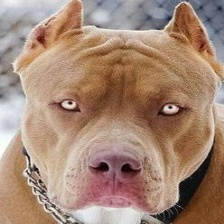

In [19]:
img = PIL.Image.open(rand_images_path)
img

In [20]:
predicted_breed = predict_breed(rand_images_path)

1/1 [==============================] - 1s 1s/step


In [21]:
regex = r"valid\/(.+?)\/"
match = re.search(regex, rand_images_path)
subfolder = match.group(1)

In [22]:
print(f"Predicted Breed: {predicted_breed}")
print(f"Actual Breed: {subfolder}")

Predicted Breed: Pit Bull
Actual Breed: Pit Bull


So the model works correctly!